In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

SEED = 0

## Load dataset

In [2]:
df = pd.read_csv("../diabetes_prediction_dataset.csv")

## Perform cleaning and preprocessing

In [3]:
# Make a dataframe to count the null, na, and negative values
invalid_values = pd.DataFrame()
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        invalid_values[col] = [
            df[col].isnull().sum(),
            df[col].isna().sum(),
            (df[col] < 0).sum(),
        ]
    else:
        invalid_values[col] = [df[col].isnull().sum(), df[col].isna().sum(), np.NaN]
invalid_values.index = ["Null count", "NaN count", "Negative count"]

display(invalid_values)
print("There are no null, NaN, or negative values in the dataset that need cleaning.\n")

print(f"Duplicated Rows: {df.duplicated().sum()}")
# There are 3854 duplicate rows, let's drop them
df_clean = df.drop_duplicates().copy(True)

# There are 3998 "ever" values in the 'smoking_history' column, this looks like a typo
# So let's replace it with 'never'
print(
    f"""
There are {len(df_clean[df_clean['smoking_history'] == 'ever'])} "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".
"""
)
df_clean.loc[df_clean["smoking_history"] == "ever", "smoking_history"] = "never"

df_clean["smoking_history_num"] = df_clean["smoking_history"].map(
    {
        "No Info": 0,
        "never": 1,
        "former": 2,
        "not current": 3,
        "current": 4,
    }
)

df_clean["gender_num"] = df_clean["gender"].map(
    {
        "Male": 0,
        "Female": 1,
        "Other": 2,
    }
)

print(f"There are {len(df_clean)} clean rows left after dropping duplicates.")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
Null count,0.0,0,0,0,0.0,0,0,0,0
NaN count,0.0,0,0,0,0.0,0,0,0,0
Negative count,NaN,0,0,0,NaN,0,0,0,0


There are no null, NaN, or negative values in the dataset that need cleaning.

Duplicated Rows: 3854

There are 3998 "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".

There are 96146 clean rows left after dropping duplicates.


### Detect and remove invalid values

### Preprocess data into numerical and categorical features

In [4]:
categorical_columns = set(['diabetes', 'heart_disease', 'hypertension', 'gender', 'smoking_history'])
df_quantitative_columns = set(df_clean.columns).difference(set(categorical_columns))
df_quantitative = df_clean[list(df_quantitative_columns)]
df_categorical = df_clean[list(categorical_columns)]

# Models Implementation

In [5]:
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def report_model_performance(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(
        classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"])
    )

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Diabetes", "Diabetes"],
        yticklabels=["No Diabetes", "Diabetes"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

## Generalized Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               diabetes   No. Observations:                76916
Model:                            GLM   Df Residuals:                    76908
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23328.
Date:                Thu, 12 Jun 2025   Deviance:                       46657.
Time:                        00:04:47   Pearson chi2:                 2.07e+05
No. Iterations:                     6   Pseudo R-squ. (CS):          -0.008101
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
HbA1c_level            -0.1707      0.009    -18.652      0.000      -0.189      -0.153
blood_glucose_level     0.0101      0.000     36.126      0.000       0.010       0.011
age                     0.0179      0.001     29.283      0.000       0.017       0.019
bmi                    -0.1205      0.002    -56.380      0.000      -0.125      -0.116
smoking_history_num    -0.0108      0.010     -1.055      0.292      -0.031       0.009
heart_disease           0.9529      0.045     21.017      0.000       0.864       1.042
hypertension            1.2640      0.036     35.105      0.000       1.193       1.335
gender_num             -0.8319      0.024    -34.159      0.000      -0.880      -0.784
=======================================================================================
"""

Generalized Linear Model Accuracy: 0.91
              precision    recall  f1-score   support

 No Diabetes       0.92      0.99      0.95     17562
    Diabetes       0.46      0.07      0.13      1668

    accuracy                           0.91     19230
   macro avg       0.69      0.53      0.54     19230
weighted avg       0.88      0.91      0.88     19230



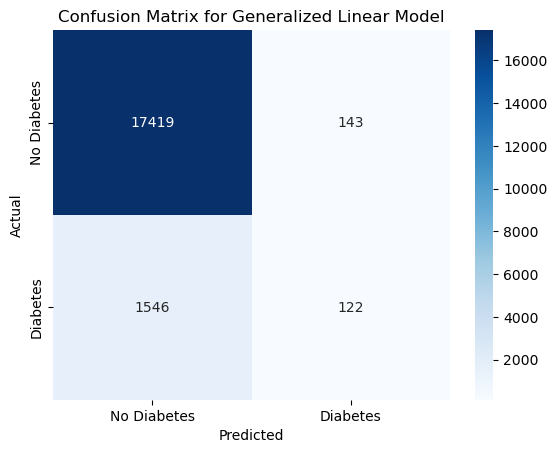

In [6]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
            "smoking_history_num",
            "heart_disease",
            "hypertension",
            "gender_num",
        ]
    ],
    df_clean["diabetes"],
    test_size=0.2,
)

glm = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()

display(glm.summary())

y_glm = glm.predict(X_test) > 0.5
report_model_performance(y_test, y_glm, "Generalized Linear Model")

## Logistic Regression

Logistic Regression Accuracy: 0.96
              precision    recall  f1-score   support

 No Diabetes       0.97      0.99      0.98     17562
    Diabetes       0.87      0.63      0.73      1668

    accuracy                           0.96     19230
   macro avg       0.92      0.81      0.85     19230
weighted avg       0.96      0.96      0.96     19230



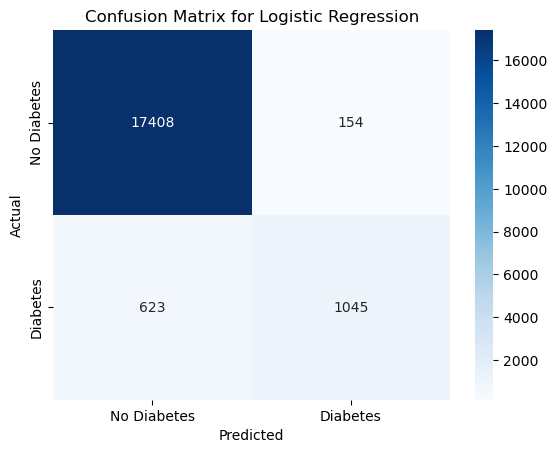

In [7]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
            # "smoking_history_num",
            # "heart_disease",
            # "hypertension",
            # "gender_num",
        ]
    ],
    df_clean["diabetes"],
    test_size=0.2,
)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_log_reg = log_reg.predict(X_test)

report_model_performance(y_test, y_log_reg, "Logistic Regression")

## KMeans Clustering

KMeans Clustering Accuracy: 0.50
              precision    recall  f1-score   support

 No Diabetes       0.99      0.45      0.62     17562
    Diabetes       0.14      0.97      0.25      1668

    accuracy                           0.50     19230
   macro avg       0.57      0.71      0.44     19230
weighted avg       0.92      0.50      0.59     19230



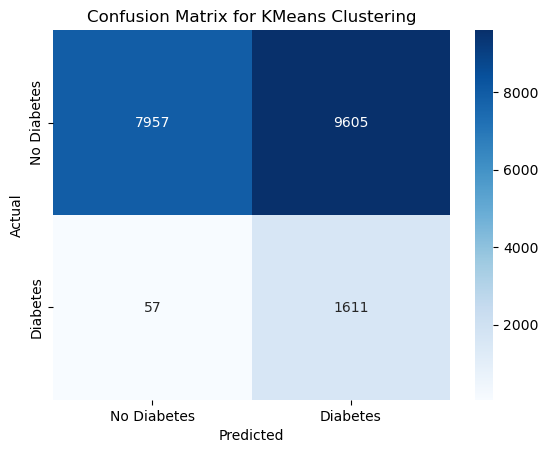

In [8]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_clean[["age", "bmi", "blood_glucose_level"]], df_clean["diabetes"], test_size=0.2
)

scaler = StandardScaler()
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaler.fit_transform(X_train))
y_kmeans = kmeans.predict(scaler.transform(X_test))

report_model_performance(y_test, y_kmeans, "KMeans Clustering")

## K-Nearest Neighbors

KNN Accuracy: 0.97
              precision    recall  f1-score   support

 No Diabetes       0.97      1.00      0.98     17562
    Diabetes       1.00      0.68      0.81      1668

    accuracy                           0.97     19230
   macro avg       0.99      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



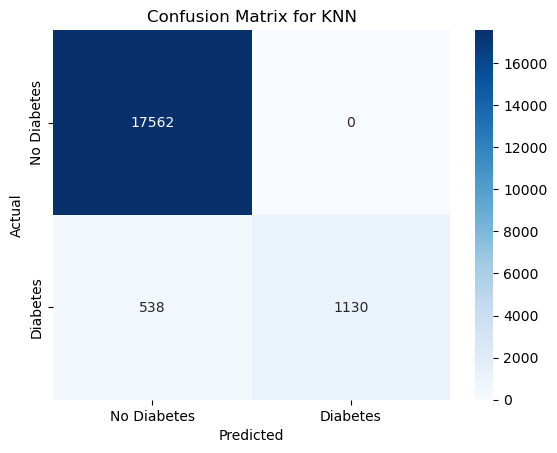

In [9]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            # "age",
            # "bmi",
            # "smoking_history_num",
            # "heart_disease",
            # "hypertension",
            # "gender_num",
        ]
    ],
    df_clean["diabetes"],
    test_size=0.2,
)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

report_model_performance(y_test, y_knn, "KNN")

## Decision Tree Classifier

Decision Tree Classifier Accuracy: 0.87
              precision    recall  f1-score   support

 No Diabetes       0.98      0.88      0.93     17562
    Diabetes       0.38      0.80      0.52      1668

    accuracy                           0.87     19230
   macro avg       0.68      0.84      0.72     19230
weighted avg       0.93      0.87      0.89     19230



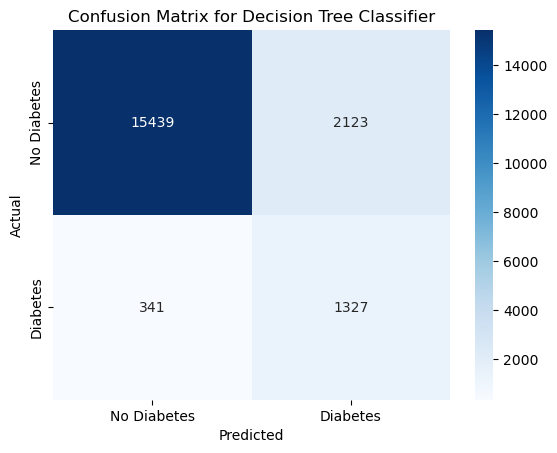

Decision Tree Classifier weighted for diabetes recall Accuracy: 0.67
              precision    recall  f1-score   support

 No Diabetes       1.00      0.64      0.78     17562
    Diabetes       0.21      1.00      0.35      1668

    accuracy                           0.67     19230
   macro avg       0.60      0.82      0.56     19230
weighted avg       0.93      0.67      0.74     19230



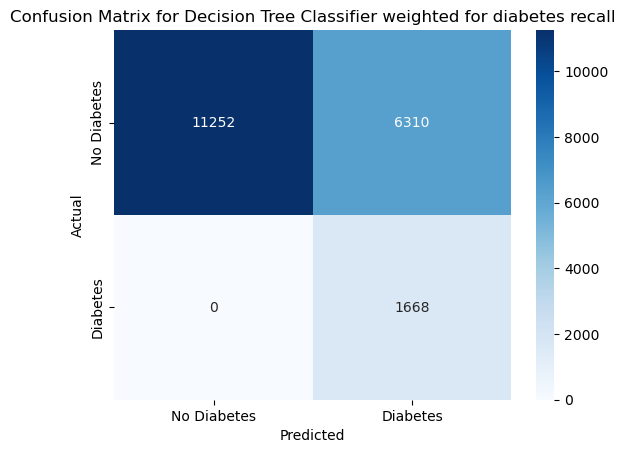

In [10]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            # "age",
            # "bmi",
            # "smoking_history_num",
            # "heart_disease",
            # "hypertension",
            # "gender_num",
        ]
    ],
    df_clean["diabetes"],
    test_size=0.2,
)

decision_tree = tree.DecisionTreeClassifier(class_weight='balanced')
decision_tree.fit(X_train, y_train)
y_decision_tree = decision_tree.predict(X_test)

report_model_performance(y_test, y_decision_tree, "Decision Tree Classifier")

decision_tree2 = tree.DecisionTreeClassifier(class_weight={0: 1, 1: 20})
decision_tree2.fit(X_train, y_train)
y_decision_tree2 = decision_tree2.predict(X_test)

report_model_performance(y_test, y_decision_tree2, "Decision Tree Classifier weighted for diabetes recall")

Decision Tree Classifier - SMOTE Resampled Accuracy: 0.88
              precision    recall  f1-score   support

 No Diabetes       0.98      0.89      0.93     17562
    Diabetes       0.39      0.79      0.53      1668

    accuracy                           0.88     19230
   macro avg       0.69      0.84      0.73     19230
weighted avg       0.93      0.88      0.89     19230



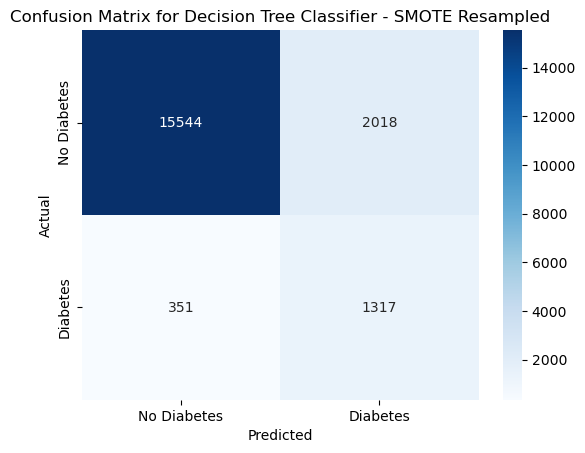

In [11]:
from imblearn.over_sampling import SMOTE
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            # "age",
            # "bmi",
            # "smoking_history_num",
            # "heart_disease",
            # "hypertension",
            # "gender_num",
        ]
    ],
    df_clean["diabetes"],
    test_size=0.2,
)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

decision_tree_smote = tree.DecisionTreeClassifier()
decision_tree_smote.fit(X_train_resampled, y_train_resampled)
y_decision_tree_smote = decision_tree_smote.predict(X_test)

report_model_performance(y_test, y_decision_tree_smote, "Decision Tree Classifier - SMOTE Resampled")